In [1]:
import numpy as np 
import pandas as pd 

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('data.csv').rename(columns={'conversion':'target','offer':'treatment'})

In [5]:
data['treatment'] = np.where(data['treatment']=='No Offer',0,1)
data

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0
63996,5,38.91,0,1,Urban,1,Phone,1,0
63997,6,29.99,1,0,Urban,1,Phone,1,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='target'),
                                                    data['target'],
                                                    test_size=0.25,  
                                                    random_state=42,
                                                    stratify=data['target'])

treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_val = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

In [29]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [16]:
cat_feature = ['zip_code', 'channel']

In [30]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True,cat_features=cat_feature))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

In [31]:
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score)
models_results['uplift@20%'].append(sm_score_2)
models_results

{'approach': ['SoloModel'],
 'uplift@10%': [0.09907173354291904],
 'uplift@20%': [0.08873405980273452]}

In [32]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_feature}, 
    estimator_ctrl_fit_params={'cat_features': cat_feature}
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

In [33]:
models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score)
models_results['uplift@20%'].append(tm_score_2)
models_results

{'approach': ['SoloModel', 'TwoModels'],
 'uplift@10%': [0.09907173354291904, 0.10399983006563712],
 'uplift@20%': [0.08873405980273452, 0.07436044494480673]}

In [34]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_feature})

uplift_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

In [35]:
models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score)
models_results['uplift@20%'].append(ct_score_2)
models_results

{'approach': ['SoloModel', 'TwoModels', 'ClassTransformation'],
 'uplift@10%': [0.09907173354291904, 0.10399983006563712, 0.09127245434784148],
 'uplift@20%': [0.08873405980273452, 0.07436044494480673, 0.08250667346404117]}

In [48]:
X_train_tree = pd.concat([X_train.drop(cat_feature,1), 
                          pd.get_dummies(X_train['zip_code'], prefix='zip_code'), 
                          pd.get_dummies(X_train['channel'], prefix='channel')], 1)
features = [col for col in X_train_tree]

In [49]:
X_train_tree

,recency,history,used_discount,used_bogo,is_referral,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
7871,9,171.78,0,1,0,0,1,0,0,1,0
16329,2,242.13,1,0,0,1,0,0,0,1,0
26888,1,185.97,1,0,1,0,1,0,0,1,0
33816,11,91.32,1,0,0,0,1,0,0,1,0
18879,1,127.05,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4734,1,324.67,1,1,0,0,1,0,0,0,1
40444,1,136.61,1,0,1,1,0,0,0,0,1
3437,11,256.08,0,1,1,0,1,0,0,0,1
27103,5,37.87,0,1,1,0,0,1,0,0,1


Wall time: 9.35 s


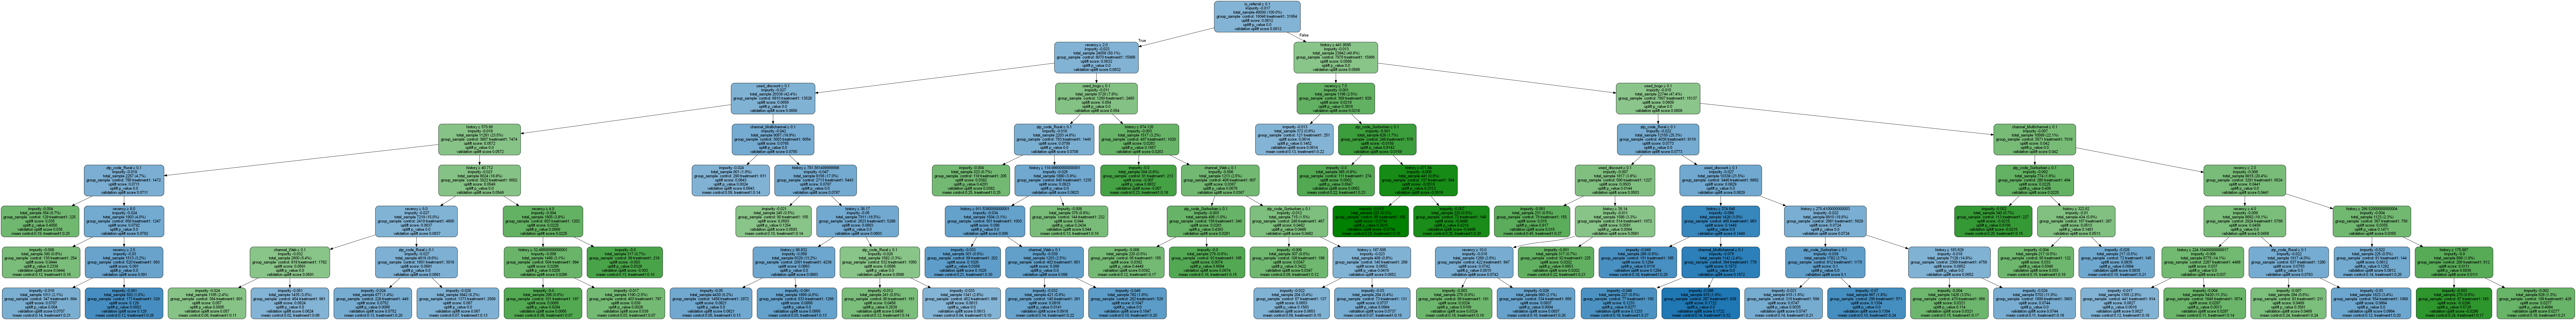

In [52]:
%%time
import causalml
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

In [ ]:
# дерево позволяет понять каким группам можно проводить акцию а каким нет 